# Setup instruction:
Step 1: Go to Runtime > Change runtime type > Change Hardware Acceleration to GPU.

Step 2: Upload dpsdata.csv to colab (open left pane - file pane, right click and click upload). **Run the cell below.**

Step 3: Create a new folder named "output", inside it create another folder named "params", inside "params" create another folder named "notef".

Step 4: Go to Runtime > Run all.

# Demand for Payment Services

In [4]:
# Step 2 - create output/params/notef
!mkdir output
!mkdir output/params
!mkdir output/params/notef

### Import libraries and basic settings

In [5]:
!pip3 install chaospy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.0/148.0 kB 22.0 MB/s eta 0:00:00


In [1]:
# chaospy generates pseudorandom sequence, e.g. Hammersley seq.
import chaospy

# GPU-enabled vector library and optimization
import torch
import torch.optim as optim

# Libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Other numerical/data libraries
import pandas as pd
import numpy as np

In [2]:
# dtype = torch.double
dtype = torch.float64
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

pd.options.mode.chained_assignment = None

np.random.seed(123456789)
torch.manual_seed(123456789)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
output_folder = './output/params/notef/'

# assert torch.__version__ == '1.1.0'

## Read the data and process it into variables

In [3]:
# Read and label Data
# data = pd.read_csv('../DATA/dpsdata.csv')
data = pd.read_csv('dpsdata.csv')
data["zeros"] = np.zeros_like(data.p.values)
data["ones"] = np.ones_like(data.p.values)
data = data[(data['urb'] == 'Rural') | (data['urb'] == 'Urban')]

## $X_{bmj}$

In [4]:
# Transaction specific dataframe
ca_data = data[['e0', 'c0', 'r0', 'zeros', 'ec0']]
dc_data = data[['e1', 'c1', 'r1', 'zeros', 'ec1']]
cc_data = data[['e2', 'c2', 'r2', 'rew', 'ec2']]

# create X
X_ca = torch.tensor(ca_data.values, dtype=dtype, device=device)
X_dc = torch.tensor(dc_data.values, dtype=dtype, device=device)
X_cc = torch.tensor(cc_data.values, dtype=dtype, device=device)

## $Z_{bj}$

In [5]:
# Create demographic variables
dem_data = data[['empd', 'mard', 'age', 'incl', 'gen',  'edu', 'ttype', 'urb', 'own', 'can', 'year', 'sph']]
dem_data_t = pd.get_dummies(dem_data, columns=['edu', 'ttype', 'year', 'urb']) # Convert categorical to dummies and drop the base cases
dem_data_t = dem_data_t.drop(['edu_Some/completed public school/some high school', 'ttype_Groceries/Drugs', 'year_2009', 'urb_Rural'], axis=1)
dem_data_t['const'] = data['ones']
dem_data_t['incl'] = dem_data_t['incl'] / 10000

# create tensors for Z
# print(dem_data_t['urb'].value_counts())
Zbj = torch.tensor(dem_data_t.values, dtype=dtype, device=device)

## $CS_b$

In [6]:
cs = torch.tensor(data.groupby('nid').mean()['cr_sc_avg'].values/100, dtype=dtype, device=device).unsqueeze(1)

# create tensors for CS
CSb = torch.cat((cs, cs), 1)

<ipython-input-6-8e37be254535>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cs = torch.tensor(data.groupby('nid').mean()['cr_sc_avg'].values/100, dtype=dtype, device=device).unsqueeze(1)


## $P_{M_s}, d_{bmj}, D_{b\mathcal{M}_b}$ and other auxilliary variables

In [7]:
# Merchant acceptance probabilities (transaction level)
Ms_0 = torch.tensor(data[['Ms0']].values, dtype=dtype, device=device)
Ms_1 = torch.tensor(data[['Ms01']].values, dtype=dtype, device=device)
Ms_2 = torch.tensor(data[['Ms012']].values, dtype=dtype, device=device)

# Consumer usage dummies for payment method (transaction level)
di = torch.tensor(data[['d0', 'd1', 'd2']].values, dtype=dtype, device=device)

# print(data['Mb'].unique())
# print(data.groupby('nid').mean().columns)

data['Mb'] = data['Mb'].map({
    'Credit card': 0,
    'Debit': 1,
    'Cash only': 2
})

# Consumer adoption dummies for payment bundles (consumer level)
BDi = torch.tensor(pd.get_dummies(data.groupby('nid').mean()['Mb']).values, dtype=dtype, device=device)

# Person ID (used to aggregate transaction level utility to individual level utility)
nid = torch.tensor(data['nid'].values, dtype=dtype, device=device)
nid_index = torch.nonzero(nid[..., None] == nid.unique())[:,1]
nid_matrix = torch.zeros(nid.unique().shape[0], nid.shape[0], dtype=dtype, device=device)
nid_matrix[nid_index, torch.arange(nid_index.shape[0])] = 1

# separate data into groups based on adopted bundles by buyers
Mb = torch.tensor(data['Mb'].values, dtype=dtype, device=device)
group_0_idx = (Mb == 0)
group_1_idx = (Mb == 1)
group_2_idx = (Mb == 2)

# Suppresses random coefficients
beta_mask = torch.tensor([0, 1, 1, 0, 1], dtype=dtype, device=device)

# merchant acceptance placeholders with all 0 or 1
zero = torch.tensor([0.], dtype=dtype, device=device)
year = torch.tensor(data['year'], dtype=dtype, device=device)

<ipython-input-7-4fcc955fc750>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  BDi = torch.tensor(pd.get_dummies(data.groupby('nid').mean()['Mb']).values, dtype=dtype, device=device)


### Helper functions

In [8]:
# Delta refers to the utility provided by each payment method, Ms is the acceptance probability
def stage2_choice(delta_ca, delta_dc, delta_cc, Ms_0, Ms_1, Ms_2):
    choice = torch.zeros(delta_ca.shape[0], delta_ca.shape[1], 3, dtype=dtype, device=device)
    # cash-only (group 0)
    choice[:, group_0_idx, :] = torch.cat([
                        torch.ones_like(delta_ca),
                        torch.zeros_like(delta_ca),
                        torch.zeros_like(delta_ca),
                      ], dim=2)[:, group_0_idx, :]

    # cash + debit (group 1)
    p_1 = torch.nn.functional.softmax(torch.cat([delta_ca, delta_dc], dim=2), dim=2)
    p_ca_1 = p_1[:,:,0:1]
    p_dc_1 = p_1[:,:,1:2]
    choice[:, group_1_idx, :] = torch.cat([
                        Ms_0 + (Ms_1 + Ms_2) * p_ca_1,
                        (Ms_1 + Ms_2) * p_dc_1,
                        torch.zeros_like(delta_ca)
                      ], dim=2)[:, group_1_idx, :]

    # cash + debit + credit (group 2)
    p_2 = torch.nn.functional.softmax(torch.cat([delta_ca, delta_dc, delta_cc], dim=2), dim=2)
    p_ca_2 = p_2[:,:,0:1]
    p_dc_2 = p_2[:,:,1:2]
    p_cc_2 = p_2[:,:,2:3]
    choice[:, group_2_idx, :] = torch.cat([
                        Ms_0 + Ms_1 * p_ca_1 + Ms_2 * p_ca_2,
                        Ms_1 * p_dc_1 + Ms_2 * p_dc_2,
                        Ms_2 * p_cc_2
                      ], dim=2)[:, group_2_idx, :]
    return choice

# Computes the expected maximum utiltiy from second stage. Dimension is number of transaction*1.
def stage2_bundle_emax(delta_ca, delta_dc, delta_cc, Ms_0, Ms_1, Ms_2):
    u_0 = delta_ca
    u_1 = torch.logsumexp(torch.cat([delta_ca, delta_dc], 2), dim=2, keepdim=True)
    u_2 = torch.logsumexp(torch.cat([delta_ca, delta_dc, delta_cc], 2), dim=2, keepdim=True)

    eu_0 = u_0
    eu_1 = Ms_0 * u_0 \
        + (Ms_1 + Ms_2) * u_1
    eu_2 = Ms_0 * u_0 \
        + Ms_1 * u_1 \
        + Ms_2 * u_2
    u = torch.cat((eu_0, eu_1, eu_2), dim=2)

    # Reduce it from transaction level to individual level
    utils = torch.matmul(u.transpose(1,2), nid_matrix.t()).transpose(1,2)
    return utils

# Take parameter of the model for the second stage, computes the usage probability in second stage
# and the expeted utility from usage in second stage.
def compute_avg_prob_util(mu, sd, alpha_ca, alpha_dc, alpha_cc, accept_0, accept_1, accept_2, draws):
    beta = draws * torch.exp(sd) * beta_mask + mu
    delta_ca = (beta * X_ca).sum(2, keepdim=True) + (Zbj * alpha_ca).sum(1, keepdim=True)
    delta_dc = (beta * X_dc).sum(2, keepdim=True) + (Zbj * alpha_dc).sum(1, keepdim=True)
    delta_cc = (beta * X_cc).sum(2, keepdim=True) + (Zbj * alpha_cc).sum(1, keepdim=True)
    avg_choice = stage2_choice(delta_ca, delta_dc, delta_cc, accept_0, accept_1, accept_2).mean(0)
    avg_util = stage2_bundle_emax(delta_ca, delta_dc, delta_cc, accept_0, accept_1, accept_2).mean(0)
    return avg_choice, avg_util

# Used to compute standard errors. Takes the exponent of logsd.
def compute_avg_prob_util_noexp(mu, expsd, alpha_ca, alpha_dc, alpha_cc, accept_0, accept_1, accept_2, draws):
    beta = draws * expsd * beta_mask + mu
    delta_ca = (beta * X_ca).sum(2, keepdim=True) + (Zbj * alpha_ca).sum(1, keepdim=True)
    delta_dc = (beta * X_dc).sum(2, keepdim=True) + (Zbj * alpha_dc).sum(1, keepdim=True)
    delta_cc = (beta * X_cc).sum(2, keepdim=True) + (Zbj * alpha_cc).sum(1, keepdim=True)
    avg_choice = stage2_choice(delta_ca, delta_dc, delta_cc, accept_0, accept_1, accept_2).mean(0)
    avg_util = stage2_bundle_emax(delta_ca, delta_dc, delta_cc, accept_0, accept_1, accept_2).mean(0)
    return avg_choice, avg_util

# Calculates the s.e.of fobjective with respect to input
def se_calc_finitediff(fobjective, inp, eps=1e-6):
    grads = []
    for i in range(len(inp)):
        inpminus = inp.clone()
        inpminus[i] = inpminus[i] - eps
        objminus = fobjective(inpminus)

        inpplus = inp.clone()
        inpplus[i] = inpplus[i] + eps
        objplus = fobjective(inpplus)
        grads.append((objplus - objminus) / (2 * eps))
    j = torch.stack(grads, 1)
    return j.t().mm(j).inverse().diag().sqrt()

# returns log-likelihood of second stage given prediction and data
def stage2_loglik(choice_prob, observed_outcome):
    return -torch.log(torch.pow(choice_prob, observed_outcome)).sum(1)

# returns log-likelihood of first stage given prediction and data
def stage1_loglik(F, gamma, util, BDi):
    fixed_cost = torch.cat((zero, F))
    variable_cost = torch.cat((torch.zeros_like(cs), CSb * gamma), 1)
    util_after_cost = util + fixed_cost + variable_cost
    likelihood = torch.nn.functional.softmax(util_after_cost, dim=1)
    return -torch.log(torch.pow(likelihood, BDi)).sum(1)

# read param from a file
def get_params_from(filename):
    p = np.load(output_folder + filename, allow_pickle=True).item()
    mu = torch.tensor(p['beta'], dtype=dtype, device=device, requires_grad=True)
    if 'sd' in p.keys():
        sd = torch.tensor(p['sd'], dtype=dtype, device=device, requires_grad=True)
    else:
        sd = torch.zeros(X_ca.shape[1], dtype=dtype, device=device, requires_grad=True)
    alpha_ca = torch.tensor(p['alpha_ca'], dtype=dtype, device=device, requires_grad=True)
    alpha_dc = torch.tensor(p['alpha_dc'], dtype=dtype, device=device, requires_grad=True)
    alpha_cc = torch.tensor(p['alpha_cc'], dtype=dtype, device=device, requires_grad=True)
    F = torch.tensor(p['F'], dtype=dtype, device=device, requires_grad=True)
    if 'gamma' in p.keys():
        gamma = torch.tensor(p['gamma'], dtype=dtype, device=device, requires_grad=True)
    else:
        gamma = torch.zeros(CSb.shape[1], 1, dtype=dtype, device=device, requires_grad=True)
    draws = torch.tensor(p['draws'], dtype=dtype, device=device, requires_grad=True)
    ll = torch.tensor(p['ll'], dtype=dtype, device=device, requires_grad=True)
    return mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, draws, ll

# save param except standard error to a file
def save_param_nose_to(filename, mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, draws, l):
    np.save(output_folder + filename, {
      'beta': mu.detach().cpu().numpy(),
      'sd': sd.detach().cpu().numpy(),
      'alpha_ca': alpha_ca.detach().cpu().numpy(),
      'alpha_dc': alpha_dc.detach().cpu().numpy(),
      'alpha_cc': alpha_cc.detach().cpu().numpy(),
      'F': F.detach().cpu().numpy(),
      'gamma': gamma.detach().cpu().numpy(),
      'draws': draws.detach().cpu().numpy(),
      'll': l.detach().cpu().numpy(),
    })

# save all param to a file
def save_param_to(filename, mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, mu_se, sd_se, alpha_dc_se, alpha_cc_se, F_se, gamma_se, draws, ll):
    np.save(output_folder + filename, {
      'beta': mu.detach().cpu().numpy(),
      'sd': sd.detach().cpu().numpy(),
      'alpha_ca': alpha_ca.detach().cpu().numpy(),
      'alpha_dc': alpha_dc.detach().cpu().numpy(),
      'alpha_cc': alpha_cc.detach().cpu().numpy(),
      'F': F.detach().cpu().numpy(),
      'gamma': gamma.detach().cpu().numpy(),
      'draws': draws.detach().cpu().numpy(),
      'beta_se': mu_se.detach().cpu().numpy(),
      'sd_se': sd_se.detach().cpu().numpy(),
      'alpha_dc_se': alpha_dc_se.detach().cpu().numpy(),
      'alpha_cc_se': alpha_cc_se.detach().cpu().numpy(),
      'F_se': F_se.detach().cpu().numpy(),
      'gamma_se': gamma_se.detach().cpu().numpy(),
      'll': ll.detach().cpu().numpy(),
    })

# Some packaged functions given only one parameter, used to calculate the standard error
def ll2mu(mu1):
    avg_choice, avg_util = compute_avg_prob_util(mu1, sd,
                        alpha_ca, alpha_dc, alpha_cc,
                        Ms_0, Ms_1, Ms_2, draws)
    return stage2_loglik(avg_choice, di)

def ll2sd(sd):
    sd1 = torch.tensor([0, sd[0], sd[1], 0, sd[2]], dtype=dtype, requires_grad=True, device=device)
    avg_choice, avg_util = compute_avg_prob_util_noexp(mu, sd1,
                        alpha_ca, alpha_dc, alpha_cc,
                        Ms_0, Ms_1, Ms_2, draws)
    return stage2_loglik(avg_choice, di)

def ll2dc(alpha_dc1):
    avg_choice, avg_util = compute_avg_prob_util(mu, sd,
                        alpha_ca, alpha_dc1, alpha_cc,
                        Ms_0, Ms_1, Ms_2, draws)
    return stage2_loglik(avg_choice, di)

def ll2cc(alpha_cc1):
    avg_choice, avg_util = compute_avg_prob_util(mu, sd,
                        alpha_ca, alpha_dc, alpha_cc1,
                        Ms_0, Ms_1, Ms_2, draws)
    return stage2_loglik(avg_choice, di)

def ll1F(F1):
    avg_choice, avg_util = compute_avg_prob_util(mu, sd,
                        alpha_ca, alpha_dc, alpha_cc,
                        Ms_0, Ms_1, Ms_2, draws)
    return stage1_loglik(F1, gamma, avg_util, BDi)

def ll1betaF(gamma1):
    avg_choice, avg_util = compute_avg_prob_util(mu, sd,
                        alpha_ca, alpha_dc, alpha_cc,
                        Ms_0, Ms_1, Ms_2, draws)
    return stage1_loglik(F, gamma1, avg_util, BDi)

In [9]:
# Fits the model given optimizer and LR scheduler
def fit(optimizer, scheduler, mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, draws):
    ls = []
    for i in range(opt['iter']):
        optimizer.zero_grad()
        avg_choice, avg_util = compute_avg_prob_util(mu, sd,
                            alpha_ca, alpha_dc, alpha_cc,
                            Ms_0, Ms_1, Ms_2, draws)
        l = torch.sum(stage2_loglik(avg_choice, di)) + torch.sum(stage1_loglik(F, gamma, avg_util, BDi))
        ls.append(float(l))
        l.backward()
        optimizer.step()
        scheduler.step(l)
        if (i+1) % (500) == 0:
            print('------------------------------------------------------')
            print("LL", l.detach().cpu().numpy().round(4))
            print("Mu", mu.detach().cpu().numpy().round(4))
            print("SD", torch.exp(sd).detach().cpu().numpy().round(4))
            print("F", F.detach().cpu().numpy().round(4))
            print("beta F", gamma.detach().cpu().numpy().round(4))
            print('------------------------------------------------------')
            print()
        if scheduler.optimizer.param_groups[0]['lr'] < 1e-7:
            print('Converged')
            break
        if torch.isnan(l):
            print('NAN')
            break

    print("Joint LL: {:.3f}".format(l))
    plt.plot(ls)
    plt.show()
    return l

# Estimation (if NaN just restart)

## Spec 1 Conditional Logit

In [15]:
opt = {'iter': 10000, 'lr': 0.001, 'amsgrad': True}

In [16]:
draws = torch.zeros(1, nid.unique().shape[0], X_ca.shape[1], dtype=dtype, device=device)[:, nid_index, :]

------------------------------------------------------
LL inf
Mu [ 1.2835 -0.3402  1.466   0.6952 -0.8931]
SD [1. 1. 1. 1. 1.]
F [-0.866   0.8345]
beta F [0. 0.]
------------------------------------------------------

------------------------------------------------------
LL inf
Mu [ 1.2871 -0.3345  1.4716  0.6909 -0.8986]
SD [1. 1. 1. 1. 1.]
F [-0.8721  0.8282]
beta F [0. 0.]
------------------------------------------------------

Converged
Joint LL: inf


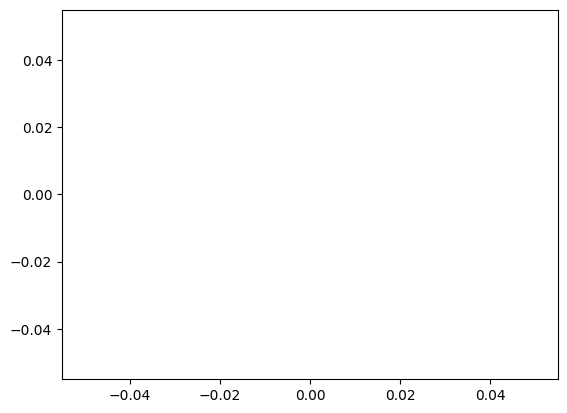

In [17]:
# no sd, no gamma
mu = torch.randn(X_ca.shape[1], dtype=dtype, requires_grad=True, device=device)
sd = torch.zeros(X_ca.shape[1], dtype=dtype, requires_grad=False, device=device)
alpha_ca = torch.zeros(Zbj.shape[1], dtype=dtype, requires_grad=False, device=device)
alpha_dc = torch.randn(Zbj.shape[1], dtype=dtype, requires_grad=True, device=device)
alpha_cc = torch.randn(Zbj.shape[1], dtype=dtype, requires_grad=True, device=device)
F = torch.randn(CSb.shape[1], dtype=dtype, requires_grad=True, device=device)
gamma = torch.zeros(CSb.shape[1], dtype=dtype, requires_grad=False, device=device)

optimizer = optim.Adam([mu, alpha_dc, alpha_cc, F], opt['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100, threshold=1e-8, threshold_mode='abs')
l = fit(optimizer, scheduler, mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, draws)

save_param_nose_to('spec1_asc', mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, draws, l)

In [18]:
# Run this on CPU with a lot of memory
mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, draws, l = get_params_from('spec1_asc.npy')
mu_se = se_calc_finitediff(ll2mu, mu, eps=1e-12)
sd_se = torch.tensor([0, 0, 0, 0, 0])
alpha_dc_se = se_calc_finitediff(ll2dc, alpha_dc, eps=1e-12)
alpha_cc_se = se_calc_finitediff(ll2cc, alpha_cc, eps=1e-12)
F_se = se_calc_finitediff(ll1F, F, eps=1e-12)
gamma_se = se_calc_finitediff(ll1betaF, gamma, eps=1e-12)
save_param_to('spec1_asc', mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, mu_se, sd_se, alpha_dc_se, alpha_cc_se, F_se, gamma_se, draws, l)

## Spec 2 Mix

In [22]:
opt = {'iter': 10000, 'lr': 0.1, 'num_sample':100, 'amsgrad': True}

In [23]:
base_dist = chaospy.Normal(0,1)
dist = chaospy.Iid(base_dist, X_ca.shape[1])
samples = chaospy.distributions.sampler.sequences.hammersley.create_hammersley_samples(order=opt['num_sample']*nid.unique().shape[0], dim=X_ca.shape[1], burnin=-1)
draws = torch.tensor(dist.inv(samples).T.reshape(opt['num_sample'], nid.unique().shape[0], X_ca.shape[1]), dtype=dtype, device=device)[:, nid_index, :]

In [24]:
# no gamma
mu = torch.randn(X_ca.shape[1], dtype=dtype, requires_grad=True, device=device)
sd = torch.randn(X_ca.shape[1], dtype=dtype, requires_grad=True, device=device)
alpha_ca = torch.zeros(Zbj.shape[1], dtype=dtype, requires_grad=False, device=device)
alpha_dc = torch.randn(Zbj.shape[1], dtype=dtype, requires_grad=True, device=device)
alpha_cc = torch.randn(Zbj.shape[1], dtype=dtype, requires_grad=True, device=device)
F = torch.randn(2, dtype=dtype, requires_grad=True, device=device)
gamma = torch.zeros(CSb.shape[1], dtype=dtype, requires_grad=False, device=device)

optimizer = optim.Adam([mu, sd, alpha_dc, alpha_cc, F], opt['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100, threshold=1e-8, threshold_mode='abs')
l = fit(optimizer, scheduler, mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, draws)

save_param_nose_to('spec2_mix', mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, draws, l)

KeyboardInterrupt: ignored

In [25]:
# Run this on CPU with a lot of memory
mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, draws, l = get_params_from('spec2_mix.npy')
mu_se = se_calc_finitediff(ll2mu, mu, eps=1e-12)
sd_se = se_calc_finitediff(ll2sd, torch.exp(sd[[1,2,4]]), eps=1e-12)
sd_se = torch.tensor([0, sd_se[0], sd_se[1], 0, sd_se[2]])
alpha_dc_se = se_calc_finitediff(ll2dc, alpha_dc, eps=1e-12)
alpha_cc_se = se_calc_finitediff(ll2cc, alpha_cc, eps=1e-12)
F_se = se_calc_finitediff(ll1F, F, eps=1e-12)
gamma_se = se_calc_finitediff(ll1betaF, gamma, eps=1e-12)
save_param_to('spec2_mix', mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, mu_se, sd_se, alpha_dc_se, alpha_cc_se, F_se, gamma_se, draws, l)

FileNotFoundError: ignored

## Spec 3 Mix with credit score

In [26]:
opt = {'iter': 10000, 'lr': 0.1, 'num_sample':100, 'amsgrad': True}

In [27]:
# Draw Hammersley sequences
base_dist = chaospy.Normal(0,1)
dist = chaospy.Iid(base_dist, X_ca.shape[1])
samples = chaospy.distributions.sampler.sequences.hammersley.create_hammersley_samples(order=opt['num_sample']*nid.unique().shape[0], dim=X_ca.shape[1], burnin=-1)
draws = torch.tensor(dist.inv(samples).T.reshape(opt['num_sample'], nid.unique().shape[0], X_ca.shape[1]), dtype=dtype, device=device)[:, nid_index, :]

NAN
Joint LL: nan


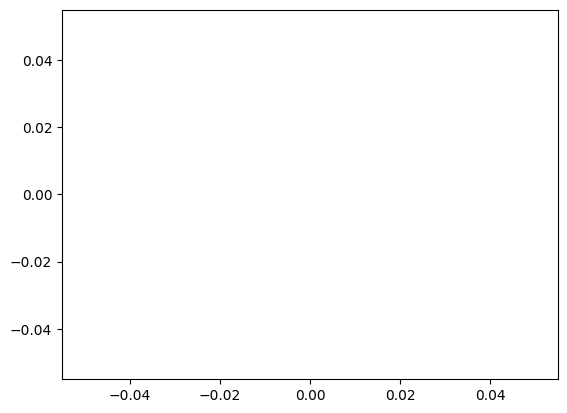

In [28]:
mu = torch.randn(X_ca.shape[1], dtype=dtype, requires_grad=True, device=device)
sd = torch.randn(X_ca.shape[1], dtype=dtype, requires_grad=True, device=device)
alpha_ca = torch.zeros(Zbj.shape[1], dtype=dtype, requires_grad=False, device=device)
alpha_dc = torch.randn(Zbj.shape[1], dtype=dtype, requires_grad=True, device=device)
alpha_cc = torch.randn(Zbj.shape[1], dtype=dtype, requires_grad=True, device=device)
F = torch.randn(2, dtype=dtype, requires_grad=True, device=device)
gamma = torch.randn(CSb.shape[1], dtype=dtype, requires_grad=True, device=device)

optimizer = optim.Adam([mu, sd, alpha_dc, alpha_cc, F, gamma], opt['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100, threshold=1e-8, threshold_mode='abs')
l = fit(optimizer, scheduler, mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, draws)

save_param_nose_to('spec3_mix_cs', mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, draws, l)

In [37]:
# Run this on CPU with a lot of memory
mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, draws, l = get_params_from('spec3_mix_cs.npy')
mu_se = se_calc_finitediff(ll2mu, mu, eps=1e-12)
sd_se = se_calc_finitediff(ll2sd, torch.exp(sd[[1,2,4]]), eps=1e-12)
sd_se = torch.tensor([0, sd_se[0], sd_se[1], 0, sd_se[2]])
alpha_dc_se = se_calc_finitediff(ll2dc, alpha_dc, eps=1e-12)
alpha_cc_se = se_calc_finitediff(ll2cc, alpha_cc, eps=1e-12)
F_se = se_calc_finitediff(ll1F, F, eps=1e-12)
gamma_se = se_calc_finitediff(ll1betaF, gamma, eps=1e-12)
save_param_to('spec3_mix_cs', mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, mu_se, sd_se, alpha_dc_se, alpha_cc_se, F_se, gamma_se, draws, l)

OutOfMemoryError: ignored

## Second stage only, analyze util gain

In [10]:
# Take the counterfactual scenario of CBDC and computes re-normalized variables
def renormalize(X_bc):
    X_sum = X_ca + X_dc + X_cc + X_bc
    X_ca_renorm = torch.cat(((X_ca / X_sum)[:,:3], X_ca[:,3:5]), 1)
    X_bc_renorm = torch.cat(((X_bc / X_sum)[:,:3], X_bc[:,3:5]), 1)
    X_dc_renorm = torch.cat(((X_dc / X_sum)[:,:3], X_dc[:,3:5]), 1)
    X_cc_renorm = torch.cat(((X_cc / X_sum)[:,:3], X_cc[:,3:5]), 1)
    return X_ca_renorm, X_bc_renorm, X_dc_renorm, X_cc_renorm

# The expected maximum utility of adopting a payment bundle
def stage1_emax_ctf(F, gamma, stage2_emax):
    fixed_cost = torch.cat((zero, F))
    variable_cost = torch.cat((torch.zeros_like(cs), CSb * gamma), 1)
    util_after_cost = stage2_emax + fixed_cost + variable_cost
    return torch.logsumexp(util_after_cost, dim=2, keepdim=True)

# The expected maximum utility of each transaction
def stage2_bundle_emax_ctf(delta_ca, delta_bc, delta_dc, delta_cc, accept_prob_0, accept_prob_1, accept_prob_2):
    u_0 = torch.logsumexp(torch.cat([delta_ca, delta_bc], 2), dim=2, keepdim=True)
    u_1 = torch.logsumexp(torch.cat([delta_ca, delta_bc, delta_dc], 2), dim=2, keepdim=True)
    u_2 = torch.logsumexp(torch.cat([delta_ca, delta_bc, delta_dc, delta_cc], 2), dim=2, keepdim=True)

    eu_0 = u_0
    eu_1 = accept_prob_0 * u_0 \
        + (accept_prob_1 + accept_prob_2) * u_1
    eu_2 = accept_prob_0 * u_0 \
        + accept_prob_1 * u_1 \
        + accept_prob_2 * u_2
    u = torch.cat((eu_0, eu_1, eu_2), dim=2)
    utils = torch.matmul(u.transpose(1,2), nid_matrix.t()).transpose(1,2)
    return utils

# Computes adoption prob of each bundle
def adoption_prob_ctf(F, gamma, util):
    fixed_cost = torch.cat((zero, F))
    variable_cost = torch.cat((torch.zeros_like(cs), CSb * gamma), 1)
    util_after_cost = util + fixed_cost + variable_cost
    likelihood = torch.nn.functional.softmax(util_after_cost, dim=2)
    return likelihood

# Computes usage prob of each payment method, difference is that this doesn't condition on adoption decision
# since it takes adoption probability instead. (We do not observe the adoption decision in counterfactual)
def usage_prob_ctf(delta_ca, delta_bc, delta_dc, delta_cc, accept_prob_0, accept_prob_1, accept_prob_2, adopt_prob_0, adopt_prob_1, adopt_prob_2):
    # Prob if bundle 0 adopted
    p_0 = torch.nn.functional.softmax(torch.cat([delta_ca, delta_bc], dim=2), dim=2)
    p_ca_0 = p_0[:,:,0:1]
    p_bc_0 = p_0[:,:,1:2]
    # Prob if bundle 1 adopted
    p_1 = torch.nn.functional.softmax(torch.cat([delta_ca, delta_bc, delta_dc], dim=2), dim=2)
    p_ca_1 = p_1[:,:,0:1]
    p_bc_1 = p_1[:,:,1:2]
    p_dc_1 = p_1[:,:,2:3]
    # Prob if bundle 2 adopted
    p_2 = torch.nn.functional.softmax(torch.cat([delta_ca, delta_bc, delta_dc, delta_cc], dim=2), dim=2)
    p_ca_2 = p_2[:,:,0:1]
    p_bc_2 = p_2[:,:,1:2]
    p_dc_2 = p_2[:,:,2:3]
    p_cc_2 = p_2[:,:,3:4]

    p_ca = p_ca_0 * adopt_prob_0 \
            + p_ca_0 * (adopt_prob_1 + adopt_prob_2) * accept_prob_0 \
            + p_ca_1 * adopt_prob_1 * (accept_prob_1 + accept_prob_2) \
            + p_ca_1 * adopt_prob_2 * accept_prob_1 \
            + p_ca_2 * adopt_prob_2 * accept_prob_2

    p_bc = p_bc_0 * adopt_prob_0 \
            + p_bc_0 * (adopt_prob_1 + adopt_prob_2) * accept_prob_0 \
            + p_bc_1 * adopt_prob_1 * (accept_prob_1 + accept_prob_2) \
            + p_bc_1 * adopt_prob_2 * accept_prob_1 \
            + p_bc_2 * adopt_prob_2 * accept_prob_2

    p_dc = p_dc_1 * adopt_prob_1 * (accept_prob_1 + accept_prob_2) \
            + p_dc_1 * adopt_prob_2 * accept_prob_1 \
            + p_dc_2 * adopt_prob_2 * accept_prob_2

    p_cc = p_cc_2 * adopt_prob_2 * accept_prob_2

    return torch.cat((p_ca, p_bc, p_dc, p_cc), dim=2)

# Computes probability of adoption and usage given counterfactual inputs
def compute_avg_prob_util_ctf(X0, X1, X2, Xbc, mu, sd,
                            alpha_ca, alpha_dc, alpha_cc, alpha_bc,
                            F, gamma, accept_0, accept_1, accept_2, draws):
    beta = draws * torch.exp(sd) * beta_mask + mu
    delta_ca = (beta * X0).sum(2, keepdim=True) + (Zbj * alpha_ca).sum(1, keepdim=True)
    delta_bc = (beta * Xbc).sum(2, keepdim=True) + (Zbj * alpha_bc).sum(1, keepdim=True)
    delta_dc = (beta * X1).sum(2, keepdim=True) + (Zbj * alpha_dc).sum(1, keepdim=True)
    delta_cc = (beta * X2).sum(2, keepdim=True) + (Zbj * alpha_cc).sum(1, keepdim=True)
    avg_util = stage2_bundle_emax_ctf(delta_ca, delta_bc, delta_dc, delta_cc, accept_0, accept_1, accept_2)
    adopt_prob = adoption_prob_ctf(F, gamma, avg_util)
    adopt_prob_expanded = adopt_prob[:, nid_index.long(), :]
    avg_choice = usage_prob_ctf(delta_ca, delta_bc, delta_dc, delta_cc,
                                          accept_0, accept_1, accept_2,
                                          adopt_prob_expanded[:, :, 0:1], adopt_prob_expanded[:, :, 1:2], adopt_prob_expanded[:, :, 2:3])
    return avg_choice.mean(0), adopt_prob.mean(0)

In [11]:
opt = {'iter': 10000, 'lr': 0.1, 'num_sample':100, 'amsgrad': True}

In [12]:
# Draw Hammersley sequences
base_dist = chaospy.Normal(0,1)
dist = chaospy.Iid(base_dist, X_ca.shape[1])
samples = chaospy.distributions.sampler.sequences.hammersley.create_hammersley_samples(order=opt['num_sample']*nid.unique().shape[0], dim=X_ca.shape[1], burnin=-1)
draws = torch.tensor(dist.inv(samples).T.reshape(opt['num_sample'], nid.unique().shape[0], X_ca.shape[1]), dtype=dtype, device=device)[:, nid_index, :]

In [ ]:
mu = torch.randn(X_ca.shape[1], dtype=dtype, requires_grad=True, device=device)
sd = torch.randn(X_ca.shape[1], dtype=dtype, requires_grad=True, device=device)
alpha_ca = torch.zeros(Zbj.shape[1], dtype=dtype, requires_grad=False, device=device)
alpha_dc = torch.randn(Zbj.shape[1], dtype=dtype, requires_grad=True, device=device)
alpha_cc = torch.randn(Zbj.shape[1], dtype=dtype, requires_grad=True, device=device)
F = torch.randn(2, dtype=dtype, requires_grad=False, device=device)
gamma = torch.randn(CSb.shape[1], dtype=dtype, requires_grad=False, device=device)

optimizer = optim.Adam([mu, sd, alpha_dc, alpha_cc], opt['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100, threshold=1e-8, threshold_mode='abs')

ls = []
for i in range(opt['iter']):
    optimizer.zero_grad()
    avg_choice, avg_util = compute_avg_prob_util(mu, sd,
                        alpha_ca, alpha_dc, alpha_cc,
                        Ms_0, Ms_1, Ms_2, draws)
    l = torch.sum(stage2_loglik(avg_choice, di))
    ls.append(float(l))
    l.backward()
    optimizer.step()
    scheduler.step(l)
    if (i+1) % (500) == 0:
        print('------------------------------------------------------')
        print("LL", l.detach().cpu().numpy().round(4))
        print("Mu", mu.detach().cpu().numpy().round(4))
        print("SD", torch.exp(sd).detach().cpu().numpy().round(4))
        print("F", F.detach().cpu().numpy().round(4))
        print("beta F", gamma.detach().cpu().numpy().round(4))
        print('------------------------------------------------------')
        print()
    if scheduler.optimizer.param_groups[0]['lr'] < 1e-7:
        print('Converged')
        break
    if torch.isnan(l):
        print('NAN')
        break

print("Joint LL: {:.3f}".format(l))
plt.plot(ls)
plt.show()
save_param_nose_to('spec4_mix_cs_ss', mu, sd, alpha_ca, alpha_dc, alpha_cc, F, gamma, draws, l)

In [14]:
# Best of both
X_bc = torch.max(X_ca, X_dc).clone()
X_bc[:,4] = X_dc[:,4].clone()

# Re-normalize the perception variables
X_ca_renorm, X_bc_renorm, X_dc_renorm, X_cc_renorm = renormalize(X_bc)
alpha_bc = alpha_dc

# Only in 2017
y = 2017
year_idx = (year == y)
# Compute the adoption utility WITHOUT CBDC
beta = draws[:, nid_index, :] * torch.exp(sd) * beta_mask + mu
delta_ca_nobc = (beta * X_ca_renorm).sum(2, keepdim=True) + (Zbj * alpha_ca).sum(1, keepdim=True)
delta_dc_nobc = (beta * X_dc_renorm).sum(2, keepdim=True) + (Zbj * alpha_dc).sum(1, keepdim=True)
delta_cc_nobc = (beta * X_cc_renorm).sum(2, keepdim=True) + (Zbj * alpha_cc).sum(1, keepdim=True)
stage2_emax_nocbdc = stage2_bundle_emax(delta_ca_nobc, delta_dc_nobc, delta_cc_nobc, Ms_0, Ms_1, Ms_2)

# Compute the adoption utility WITH CBDC
delta_ca = (beta * X_ca_renorm).sum(2, keepdim=True) + (Zbj * alpha_ca).sum(1, keepdim=True)
delta_bc = (beta * X_bc_renorm).sum(2, keepdim=True) + (Zbj * alpha_bc).sum(1, keepdim=True)
delta_dc = (beta * X_dc_renorm).sum(2, keepdim=True) + (Zbj * alpha_dc).sum(1, keepdim=True)
delta_cc = (beta * X_cc_renorm).sum(2, keepdim=True) + (Zbj * alpha_cc).sum(1, keepdim=True)
stage2_emax_cbdc = stage2_bundle_emax_ctf(delta_ca, delta_bc, delta_dc, delta_cc, Ms_0, Ms_1, Ms_2)


# # Convert into dollar and put it in a table
expect_util_improvement = ((stage2_emax_cbdc - stage2_emax_nocbdc).mean(0) * BDi).sum(1)[nid[year_idx].unique().long()] / float(-mu[4])
util_improvement_table = data[['nid', 'empd', 'mard', 'agec', 'incc', 'gen',  'edu',
                 'urb', 'own', 'can', 'year', 'sph']].drop_duplicates()
util_improvement_table = util_improvement_table[util_improvement_table.year == 2017]
util_improvement_table['u'] = expect_util_improvement.detach().cpu()

NameError: ignored

In [ ]:
# Group by and take mean of util improvement by demographics
util_improv_edu = util_improvement_table.groupby('edu').mean()[['u']]
util_improv_edu['eduname'] = ['High school', 'Grad School', 'Some uni.', '< high school', 'Tech. school', 'Uni degree']
util_improv_edu = util_improv_edu.sort_values(by='u', ascending=False)

util_improv_age = util_improvement_table.groupby('agec').mean()[['u']]
util_improv_age['agen'] = ['18-32', '33-42', '43-52', '53-61', '62-99']
util_improv_age = util_improv_age.sort_values(by='u', ascending=False)

util_improv_inc = util_improvement_table.groupby('incc').mean()[['u']]
util_improv_inc['incn'] = ['< 25k', '25k-45k', '45k-65k', '65k-90k', '> 90k']
util_improv_inc = util_improv_inc.sort_values(by='u', ascending=False)

mean_imp = util_improvement_table['u'].mean()

NameError: ignored

In [ ]:
util_improvement_table['u'].mean()

1.7308223664314606

NameError: ignored

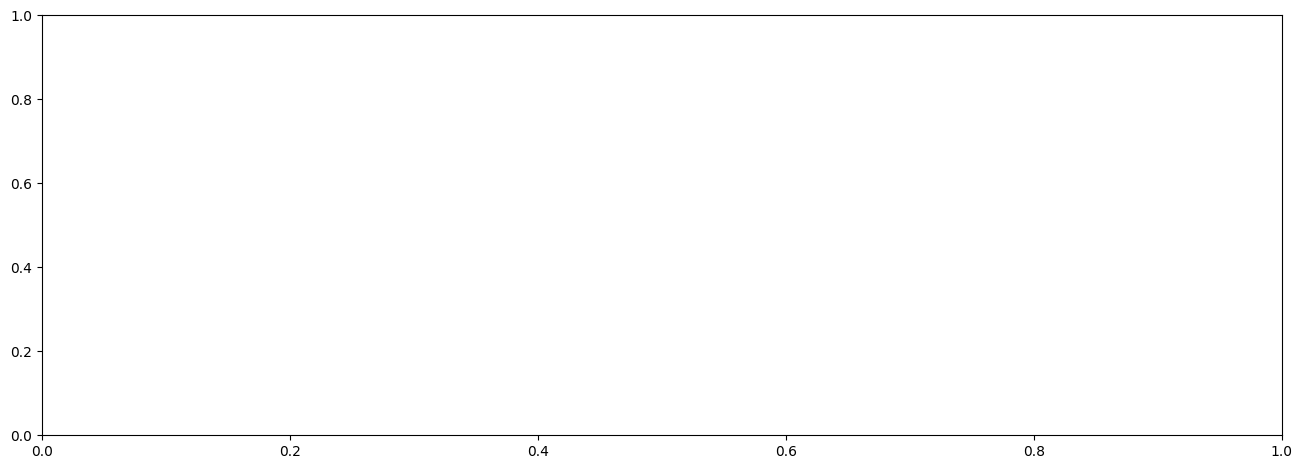

In [ ]:
# plot the distribution and breakdown of util gain
gs = gridspec.GridSpec(2,3)
plt.figure(figsize=(16,12))

ax1 = plt.subplot(gs[0, :])
plt.hist(expect_util_improvement.detach().cpu(), bins=np.arange(float(expect_util_improvement.min().round()), float(expect_util_improvement.max().ceil()), 0.25), color='dimgrey')
plt.xlabel("Utility improvement in dollars")
plt.ylabel("Person count")

ax2 = plt.subplot(gs[1, 0])
plt.bar(x=util_improv_edu['eduname'], height=util_improv_edu['u'], align='center', color='dimgrey')
plt.ylabel("Utility improvement in dollars")
plt.xticks(rotation=90)

ax3 = plt.subplot(gs[1, 1], sharey=ax2)
plt.bar(x=util_improv_age['agen'], height=util_improv_age['u'], align='center', color='dimgrey')
plt.xticks(rotation=90)
plt.setp(ax3.get_yticklabels(), visible=False)

ax4 = plt.subplot(gs[1, 2], sharey=ax2)
plt.bar(x=util_improv_inc['incn'], height=util_improv_inc['u'], align='center', color='dimgrey')
plt.xticks(rotation=90)
plt.setp(ax4.get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

# save to a file
util_improvement_table.to_csv('ecs3cl.csv', index=False)

## Elasticity (on CPU)

In [ ]:
X_ca_t = X_ca.clone()
X_dc_t = X_dc.clone()
X_cc_t = X_cc.clone()

In [ ]:
year_idx = (year == 2017)
avg_choice, avg_util = compute_avg_prob_util(mu, sd,
                        alpha_ca, alpha_dc, alpha_cc,
                        Ms_0, Ms_1, Ms_2, draws)
fixed_cost = torch.cat((zero, F))
variable_cost = torch.cat((torch.zeros_like(cs), CSb * gamma), 1)
util_after_cost = avg_util + fixed_cost + variable_cost
likelihood = torch.nn.functional.softmax(util_after_cost, dim=1)

baseline_usage = avg_choice[year_idx]
baseline_adopt = likelihood[nid[year_idx].unique().long()]

In [ ]:
eps = 1e-10
var_idxs = [0, 1, 2, 4]
var_name = ['Ease', 'Affordability', 'Risk', 'Tcost']
mb_changed = [X_ca, X_dc, X_cc]
mb_name = ['Cash', 'Debit', 'Credit']

for j in range(len(var_idxs)):
    print("Changing variable", var_name[j])
    varidx = var_idxs[j]

    for i in range(len(mb_changed)):
        var_changed = mb_changed[i]
        print("  Changing", mb_name[i])
        # Compute the baseline value for elasticity
        baseline_var = var_changed[year_idx, varidx]
        baseline_var_pp = (torch.mm(nid_matrix, var_changed) / torch.mm(nid_matrix, torch.ones_like(Ms_0)))[nid[year_idx].unique().long(), varidx]

        # Change the value by eps and compute the probability of usage and adopt
        var_changed[:,varidx] = var_changed[:,varidx] + eps
        avg_choice, avg_util = compute_avg_prob_util(mu, sd,
                                alpha_ca, alpha_dc, alpha_cc,
                                Ms_0, Ms_1, Ms_2, draws)
        util_after_cost = avg_util + fixed_cost + variable_cost
        likelihood = torch.nn.functional.softmax(util_after_cost, dim=1)

        usage = avg_choice[year_idx]
        adopt = likelihood[nid[year_idx].unique().long()]

        # Compute the non-nan elasticity mean
        e_usage = []
        e_adopt = []
        for k in range(3):
            derivative = (usage - baseline_usage) / eps
            elasticities = derivative[:,k] * baseline_var / baseline_usage[:,k]

            # idx_notnan = 1 - torch.isnan(elasticities)
            idx_notnan = ~torch.isnan(elasticities)
            elasticities_nonan = elasticities[idx_notnan]
            e_usage.append(elasticities_nonan.mean(0).detach().cpu().numpy())

            derivative = (adopt - baseline_adopt) / eps
            elasticities = derivative[:,k] * baseline_var_pp / baseline_adopt[:,k]

            # idx_notnan = 1 - torch.isnan(elasticities)
            idx_notnan = ~torch.isnan(elasticities)
            elasticities_nonan = elasticities[idx_notnan]
            e_adopt.append(elasticities_nonan.mean(0).detach().cpu().numpy())
        print('    Elasticity of usage', np.array(e_usage).round(3))
        print('    Elasticity of adopt', np.array(e_adopt).round(3))
        var_changed[:,varidx] = var_changed[:,varidx] - eps

Changing variable Ease
  Changing Cash
    Elasticity of usage [ 0. nan nan]
    Elasticity of adopt [nan nan nan]
  Changing Debit
    Elasticity of usage [ 0. nan nan]
    Elasticity of adopt [nan nan nan]
  Changing Credit
    Elasticity of usage [ 0. nan nan]
    Elasticity of adopt [nan nan nan]
Changing variable Affordability
  Changing Cash
    Elasticity of usage [ 0. nan nan]
    Elasticity of adopt [nan nan nan]
  Changing Debit
    Elasticity of usage [ 0. nan nan]
    Elasticity of adopt [nan nan nan]
  Changing Credit
    Elasticity of usage [ 0. nan nan]
    Elasticity of adopt [nan nan nan]
Changing variable Risk
  Changing Cash
    Elasticity of usage [ 0. nan nan]
    Elasticity of adopt [nan nan nan]
  Changing Debit
    Elasticity of usage [ 0. nan nan]
    Elasticity of adopt [nan nan nan]
  Changing Credit
    Elasticity of usage [ 0. nan nan]
    Elasticity of adopt [nan nan nan]
Changing variable Tcost
  Changing Cash
    Elasticity of usage [ 0. nan nan]
    Ela

# Counterfactuals

In [ ]:
# Graphical settings
plt.rcParams['figure.figsize'] = 8,6
plt.rcParams.update({'font.size': 18})

### Settings for counterfactual

In [ ]:
# Cash like
# X_bc = X_ca.clone()

# Cheaper debit
# X_bc = X_dc.clone()

# Best of both
X_bc = torch.max(X_ca, X_dc).clone()
X_bc[:,4] = X_dc[:,4].clone()

# Re-normalize the perception variables
X_ca_renorm, X_bc_renorm, X_dc_renorm, X_cc_renorm = renormalize(X_bc)

# Only in 2017
y = 2017
year_idx = (year == y)

### Observed market share

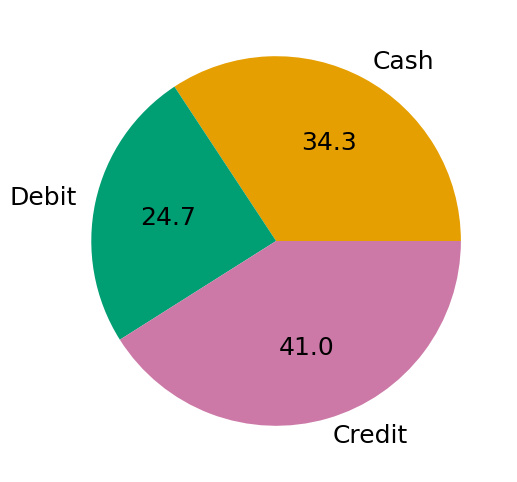

In [ ]:
plt.pie(di[year_idx].mean(0).detach().cpu(),
        labels=['Cash', 'Debit', 'Credit'],
        colors=['#E69F00', '#009E73', '#CC79A7'],
        autopct='%3.1f')
plt.show()

### Counterfactual market share

In [ ]:
mu, sd, alpha_ca, alpha_dc,\
    alpha_cc, F, gamma, draws, l = get_params_from('spec3_mix_cs.npy')

# Set CBDC mlogit params
alpha_bc = alpha_dc

avg_choice, avg_adopt = compute_avg_prob_util_ctf(X_ca_renorm, X_dc_renorm, X_cc_renorm, X_bc_renorm,
                        mu, sd, alpha_ca, alpha_dc, alpha_cc, alpha_bc, F, gamma,
                        Ms_0, Ms_1, Ms_2, draws)

print('Adopt prob', avg_adopt[nid[year_idx].unique().long()].mean(0).detach().cpu().numpy())
print('Usage prob', avg_choice[year_idx].mean(0).detach().cpu().numpy())
plt.figure(figsize=(6,6))
plt.pie(avg_choice[year_idx].mean(0).detach().cpu(),
        labels=['Cash', 'CBDC', 'Debit', 'Credit'],
        colors=['#E69F00', '#56B4E9', '#009E73', '#CC79A7'],
        autopct='%3.1f')
plt.show()

Adopt prob [nan nan nan]
Usage prob [nan nan nan nan]


ValueError: ignored

ValueError: ignored

<Figure size 600x600 with 1 Axes>

### Contribution of each variable to utility

Util mean CA [nan nan nan nan nan]
Util mean DC [nan nan nan nan nan]
Util mean CC [nan nan nan nan nan]


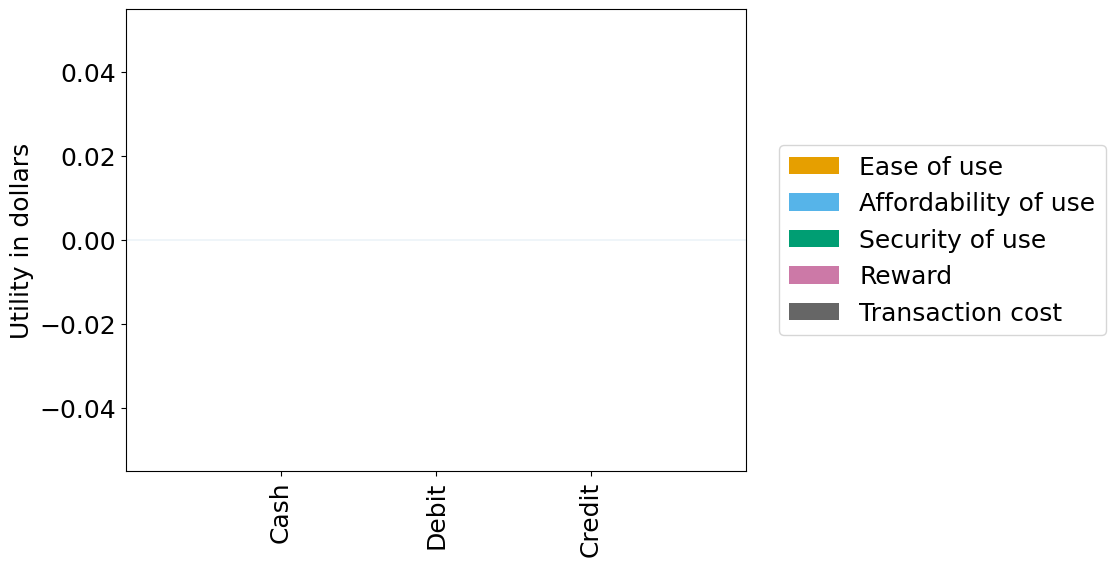

In [ ]:
# Compute the utility from the X variables and population mean
util_ca = (X_ca * mu.repeat(Zbj.shape[0],1))[year_idx]
util_dc = (X_dc * mu.repeat(Zbj.shape[0],1))[year_idx]
util_cc = (X_cc * mu.repeat(Zbj.shape[0],1))[year_idx]
util_ca_mean = util_ca.mean(0)
util_dc_mean = util_dc.mean(0)
util_cc_mean = util_cc.mean(0)

print('Util mean CA', util_ca_mean.abs().detach().cpu().numpy())
print('Util mean DC', util_dc_mean.abs().detach().cpu().numpy())
print('Util mean CC', util_cc_mean.abs().detach().cpu().numpy())

util_share = torch.stack((util_ca_mean, util_dc_mean, util_cc_mean)).t()
idx = ['Cash', 'Debit', 'Credit']
label = ['Ease of use', 'Affordability of use', 'Security of use', 'Reward', 'Transaction cost']

dd = pd.DataFrame({label[0]: util_share[0,:].detach().cpu(),
                   label[1]: util_share[1,:].detach().cpu(),
                   label[2]: util_share[2,:].detach().cpu(),
                   label[3]: util_share[3,:].detach().cpu(),
                   label[4]: util_share[4,:].detach().cpu()}, index=idx)[label]
ax = dd.plot(kind='bar', stacked=True, width=0.35, color=['#E69F00', '#56B4E9', '#009E73', '#CC79A7', '#666666'])
ax.set_ylabel('Utility in dollars')
plt.hlines(0, -1, 3, linewidth=0.1)
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5), fancybox=True)
r = ax.set_xlim(-1., 3)
plt.show()

### How cheap/good does CBDC have to be vs cash?

In [ ]:
# Cash like
# X_bc = X_ca.clone()

# Debit like
# X_bc = X_dc.clone()

# Best of both
X_bc = torch.max(X_ca, X_dc).clone()
X_bc[:,4] = X_dc[:,4].clone()

X_bc_base = X_bc.clone()
alpha_bc = alpha_dc

year_idx = (year == 2017)
start = -25
end = 30
step = 5

s_ca_cost, s_bc_cost, s_dc_cost, s_cc_cost = [], [], [], []
for multipler in range(start, end, step):
    X_bc = X_bc_base.clone()
    # Adjust the transaction cost based on the multiplier
    X_bc[:,4] = X_bc_base[:,4].clone() * (1 + multipler/100)
    X_ca_renorm, X_bc_renorm, X_dc_renorm, X_cc_renorm = renormalize(X_bc)
    choice, adopt = compute_avg_prob_util_ctf(X_ca_renorm, X_dc_renorm, X_cc_renorm, X_bc_renorm, mu, sd,
                        alpha_ca, alpha_dc, alpha_cc, alpha_bc, F, gamma,
                        Ms_0, Ms_1, Ms_2, draws)
    avg_choice = choice[year_idx].mean(0)
    s_ca_cost.append(float(avg_choice[0]))
    s_bc_cost.append(float(avg_choice[1]))
    s_dc_cost.append(float(avg_choice[2]))
    s_cc_cost.append(float(avg_choice[3]))

s_ca_perc, s_bc_perc, s_dc_perc, s_cc_perc = [], [], [], []
for multipler in range(start, end, step):
    X_bc = X_bc_base.clone()
    # Adjust all 3 perception variables based on the multiplier
    X_bc[:,:3] = X_bc_base[:,:3].clone() * (1 + multipler/100)
    X_ca_renorm, X_bc_renorm, X_dc_renorm, X_cc_renorm = renormalize(X_bc)
    choice, adopt = compute_avg_prob_util_ctf(X_ca_renorm, X_dc_renorm, X_cc_renorm, X_bc_renorm, mu, sd,
                        alpha_ca, alpha_dc, alpha_cc, alpha_bc, F, gamma,
                        Ms_0, Ms_1, Ms_2, draws)
    avg_choice = choice[year_idx].mean(0)
    s_ca_perc.append(float(avg_choice[0]))
    s_bc_perc.append(float(avg_choice[1]))
    s_dc_perc.append(float(avg_choice[2]))
    s_cc_perc.append(float(avg_choice[3]))

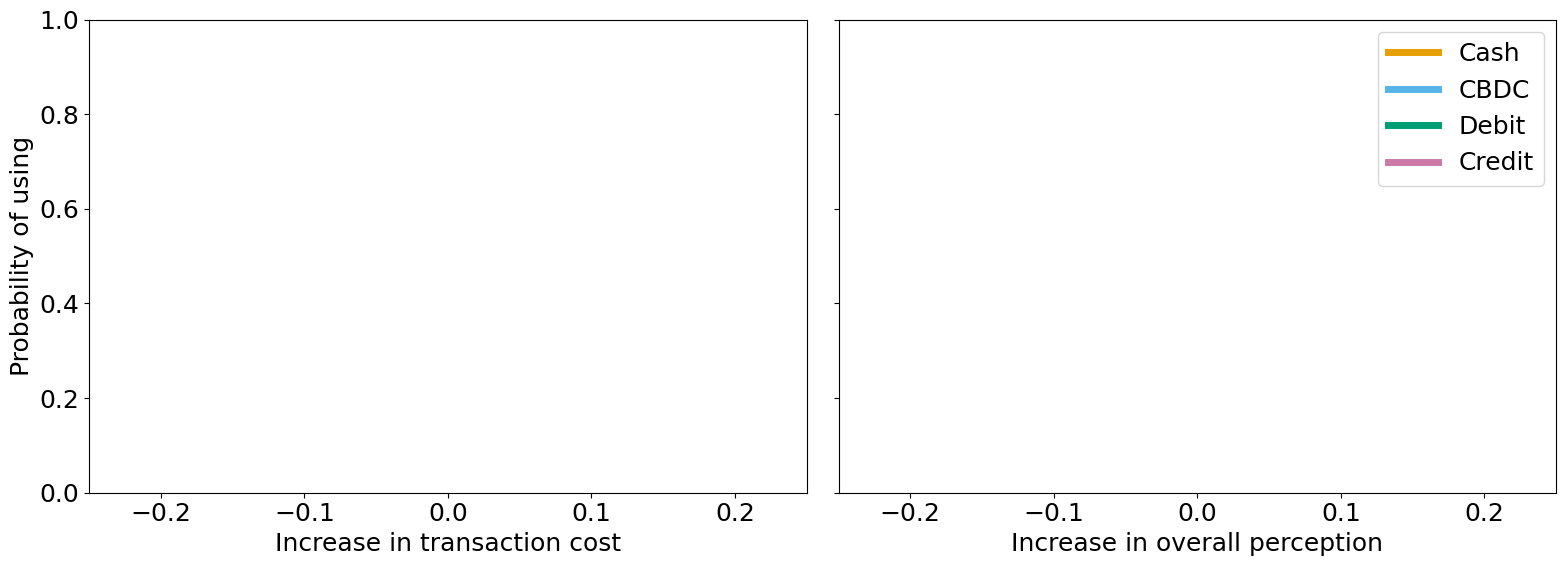

Steps
[-25 -20 -15 -10  -5   0   5  10  15  20  25]
Increase in cost
[[nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]]
Increase in perc
[[nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan]]


In [ ]:
# Plot and print the sensitivity of market share vs the changes in cost and perception.
gs = gridspec.GridSpec(1,2)
plt.figure(figsize=(16,6))
ax1 = plt.subplot(gs[0, 0])
plt.plot(np.array(range(start, end, step))/100, s_ca_cost, color='#E69F00', linewidth=5, label='Cash')
plt.plot(np.array(range(start, end, step))/100, s_bc_cost, color='#56B4E9', linewidth=5, label='CBDC')
plt.plot(np.array(range(start, end, step))/100, s_dc_cost, color='#009E73', linewidth=5, label='Debit')
plt.plot(np.array(range(start, end, step))/100, s_cc_cost, color='#CC79A7', linewidth=5, label='Credit')
plt.xlim([start/100, (end-step)/100])
plt.ylim([0, 1])
plt.xlabel('Increase in transaction cost')
plt.ylabel('Probability of using')


ax2 = plt.subplot(gs[0, 1], sharey=ax1)
plt.plot(np.array(range(start, end, step))/100, s_ca_perc, color='#E69F00', linewidth=5, label='Cash')
plt.plot(np.array(range(start, end, step))/100, s_bc_perc, color='#56B4E9', linewidth=5, label='CBDC')
plt.plot(np.array(range(start, end, step))/100, s_dc_perc, color='#009E73', linewidth=5, label='Debit')
plt.plot(np.array(range(start, end, step))/100, s_cc_perc, color='#CC79A7', linewidth=5, label='Credit')
plt.xlim([start/100, (end-step)/100])
plt.ylim([0, 1])
plt.xlabel('Increase in overall perception')
plt.legend()

plt.setp(ax2.get_yticklabels(), visible=False)
plt.tight_layout()
plt.show()

print('Steps')
print(np.array(range(start, end, step)))
print('Increase in cost')
print(np.array([s_ca_cost, s_bc_cost, s_dc_cost, s_cc_cost]).round(3))
print('Increase in perc')
print(np.array([s_ca_perc, s_bc_perc, s_dc_perc, s_cc_perc]).round(3))

### Utility contribution

### How does utility change in each situation

In [ ]:
# Cash like
# X_bc = X_ca.clone()

# Debit like
# X_bc = X_dc.clone()

# Best of both
X_bc = torch.max(X_ca, X_dc).clone()
X_bc[:,4] = X_dc[:,4].clone()

X_ca_renorm, X_bc_renorm, X_dc_renorm, X_cc_renorm = renormalize(X_bc)

alpha_bc = alpha_dc

In [ ]:
# Compute the adoption utility WITHOUT CBDC
beta = draws[:, nid_index, :] * torch.exp(sd) * beta_mask + mu
delta_ca_nobc = (beta * X_ca_renorm).sum(2, keepdim=True) + (Zbj * alpha_ca).sum(1, keepdim=True)
delta_dc_nobc = (beta * X_dc_renorm).sum(2, keepdim=True) + (Zbj * alpha_dc).sum(1, keepdim=True)
delta_cc_nobc = (beta * X_cc_renorm).sum(2, keepdim=True) + (Zbj * alpha_cc).sum(1, keepdim=True)
stage2_emax_nocbdc = stage2_bundle_emax(delta_ca_nobc, delta_dc_nobc, delta_cc_nobc, Ms_0, Ms_1, Ms_2)
emax_nocbdc = stage1_emax_ctf(F, gamma, stage2_emax_nocbdc)

# Compute the adoption utility WITH CBDC
delta_ca = (beta * X_ca_renorm).sum(2, keepdim=True) + (Zbj * alpha_ca).sum(1, keepdim=True)
delta_bc = (beta * X_bc_renorm).sum(2, keepdim=True) + (Zbj * alpha_bc).sum(1, keepdim=True)
delta_dc = (beta * X_dc_renorm).sum(2, keepdim=True) + (Zbj * alpha_dc).sum(1, keepdim=True)
delta_cc = (beta * X_cc_renorm).sum(2, keepdim=True) + (Zbj * alpha_cc).sum(1, keepdim=True)
stage2_emax_cbdc = stage2_bundle_emax_ctf(delta_ca, delta_bc, delta_dc, delta_cc, Ms_0, Ms_1, Ms_2)
emax_cbdc = stage1_emax_ctf(F, gamma, stage2_emax_cbdc)

# Convert into dollar and put it in a table
expect_util_improvement = (emax_cbdc - emax_nocbdc).mean(0).squeeze()[nid[year_idx].unique().long()] / float(-mu[4])
util_improvement_table = data[['nid', 'empd', 'mard', 'agec', 'incc', 'gen',  'edu',
                 'urb', 'own', 'can', 'year', 'sph']].drop_duplicates()
util_improvement_table = util_improvement_table[util_improvement_table.year == 2017]
util_improvement_table['u'] = expect_util_improvement.detach().cpu()

In [ ]:
# Group by and take mean of util improvement by demographics
util_improv_edu = util_improvement_table.groupby('edu').mean()[['u']]
util_improv_edu['eduname'] = ['High school', 'Grad School', 'Some uni.', '< high school', 'Tech. school', 'Uni degree']
util_improv_edu = util_improv_edu.sort_values(by='u', ascending=False)

util_improv_age = util_improvement_table.groupby('agec').mean()[['u']]
util_improv_age['agen'] = ['18-32', '33-42', '43-52', '53-61', '62-99']
util_improv_age = util_improv_age.sort_values(by='u', ascending=False)

util_improv_inc = util_improvement_table.groupby('incc').mean()[['u']]
util_improv_inc['incn'] = ['< 25k', '25k-45k', '45k-65k', '65k-90k', '> 90k']
util_improv_inc = util_improv_inc.sort_values(by='u', ascending=False)

mean_imp = util_improvement_table['u'].mean()

<ipython-input-114-df36c8fba8cf>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  util_improv_edu = util_improvement_table.groupby('edu').mean()[['u']]
<ipython-input-114-df36c8fba8cf>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  util_improv_age = util_improvement_table.groupby('agec').mean()[['u']]
<ipython-input-114-df36c8fba8cf>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  util_improv_inc = util_improvemen

ValueError: ignored

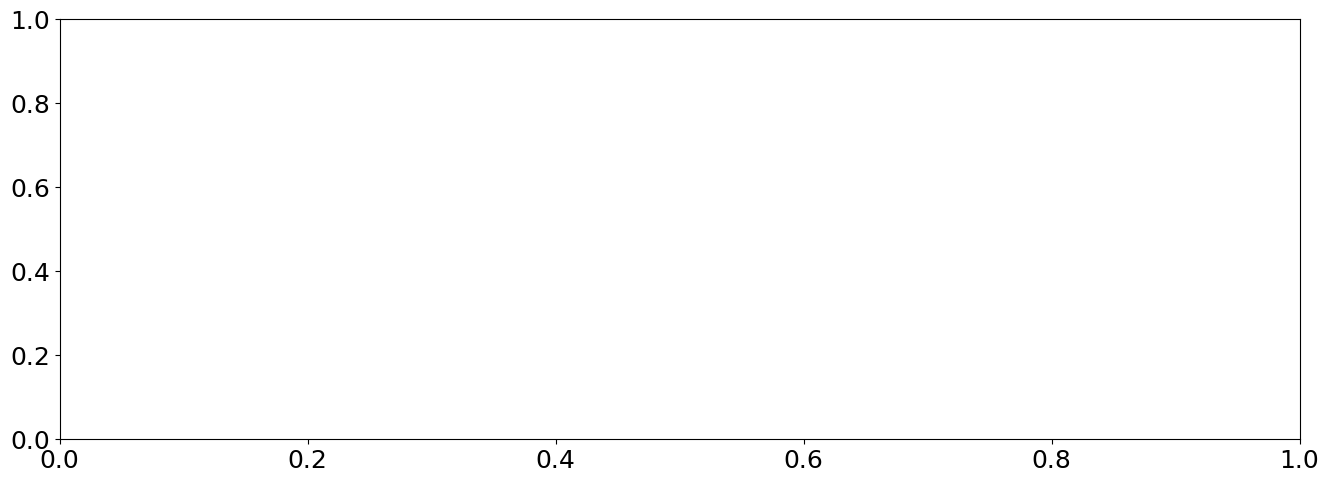

In [ ]:
# plot the distribution and breakdown of util gain
gs = gridspec.GridSpec(2,3)
plt.figure(figsize=(16,12))

ax1 = plt.subplot(gs[0, :])
plt.hist(expect_util_improvement.detach().cpu(), bins=np.arange(float(expect_util_improvement.min().round()), float(expect_util_improvement.max().ceil()), 0.25), color='dimgrey')
plt.xlabel("Utility improvement in dollars")
plt.ylabel("Person count")

ax2 = plt.subplot(gs[1, 0])
plt.bar(x=util_improv_edu['eduname'], height=util_improv_edu['u'], align='center', color='dimgrey')
plt.ylabel("Utility improvement in dollars")
plt.xticks(rotation=90)

ax3 = plt.subplot(gs[1, 1], sharey=ax2)
plt.bar(x=util_improv_age['agen'], height=util_improv_age['u'], align='center', color='dimgrey')
plt.xticks(rotation=90)
plt.setp(ax3.get_yticklabels(), visible=False)

ax4 = plt.subplot(gs[1, 2], sharey=ax2)
plt.bar(x=util_improv_inc['incn'], height=util_improv_inc['u'], align='center', color='dimgrey')
plt.xticks(rotation=90)
plt.setp(ax4.get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

# save to a file
util_improvement_table.to_csv('ecs3cl.csv', index=False)

### 6Bundles

In [ ]:
# Compute the expected maximum in the 6 bundle case. Assume CBDC bundles have no extra cost or benefit
def stage1_emax_ctf_6(F, gamma, stage2_emax, bcost=0):
    fixed_cost = torch.cat((zero, F, zero, F))
    variable_cost = torch.cat((torch.zeros_like(cs), CSb * gamma, torch.zeros_like(cs), CSb * gamma), 1)
    util_after_cost = stage2_emax + fixed_cost + variable_cost
    return torch.logsumexp(util_after_cost, dim=2, keepdim=True)

# Compute the second stage expected maximum utility given acceptance rate of 6 bundles
def stage2_bundle_emax_ctf_6(delta_ca, delta_bc, delta_dc, delta_cc, \
                                             accept_prob_0, accept_prob_1, accept_prob_2, \
                                             accept_prob_3, accept_prob_4, accept_prob_5):

    u_0_base = torch.logsumexp(torch.cat([delta_ca], 2), dim=2, keepdim=True)
    u_1_base = torch.logsumexp(torch.cat([delta_ca, delta_dc], 2), dim=2, keepdim=True)
    u_2_base = torch.logsumexp(torch.cat([delta_ca, delta_dc, delta_cc], 2), dim=2, keepdim=True)
    u_3_base = torch.logsumexp(torch.cat([delta_ca, delta_bc], 2), dim=2, keepdim=True)
    u_4_base = torch.logsumexp(torch.cat([delta_ca, delta_bc, delta_dc], 2), dim=2, keepdim=True)
    u_5_base = torch.logsumexp(torch.cat([delta_ca, delta_bc, delta_dc, delta_cc], 2), dim=2, keepdim=True)

    u_0 = u_0_base
    u_1 = (accept_prob_0 + accept_prob_3) * u_0_base \
            + (accept_prob_1 + accept_prob_2 + accept_prob_4 + accept_prob_5) * u_1_base
    u_2 = (accept_prob_0 + accept_prob_3) * u_0_base \
            + (accept_prob_1 + accept_prob_4) * u_1_base \
            + (accept_prob_2 + accept_prob_5) * u_2_base

    # compute utility of CBDC bundles
    u_3 = (accept_prob_0 + accept_prob_1 + accept_prob_2) * u_0_base \
        + (accept_prob_3 + accept_prob_4 + accept_prob_5) * u_3_base
    u_4 = accept_prob_0 * u_0_base \
            + (accept_prob_1 + accept_prob_2) * u_1_base + accept_prob_3 * u_3_base \
            + (accept_prob_4 + accept_prob_5) * u_4_base
    u_5 = accept_prob_0 * u_0_base \
            + accept_prob_1 * u_1_base \
            + accept_prob_2 * u_2_base \
            + accept_prob_3 * u_3_base \
            + accept_prob_4 * u_4_base \
            + accept_prob_5 * u_5_base

    u = torch.cat((u_0, u_1, u_2, u_3, u_4, u_5), dim=2)
    utils = torch.matmul(u.transpose(1,2), nid_matrix.t()).transpose(1,2)
    return utils

# Compute the probability of adopting any of the 6 bundles
def adoption_prob_ctf_6(F, gamma, util, bcost=0):
    fixed_cost = torch.cat((zero, F, zero - bcost , F - bcost))
    variable_cost = torch.cat((torch.zeros_like(cs), CSb * gamma.t(), torch.zeros_like(cs), CSb * gamma.t()), 1)
    util_after_cost = util + fixed_cost + variable_cost
    likelihood = torch.nn.functional.softmax(util_after_cost, dim=2)
    return likelihood

# Compute the probability of using any of the payment methods given adoption and acceptance prob of 6 bundles
def usage_prob_ctf_6(delta_ca, delta_bc, delta_dc, delta_cc, \
                             adopt_prob_0, adopt_prob_1, adopt_prob_2,\
                             adopt_prob_3, adopt_prob_4, adopt_prob_5,\
                             accept_prob_0, accept_prob_1, accept_prob_2, \
                             accept_prob_3, accept_prob_4, accept_prob_5):
    p_0 = torch.nn.functional.softmax(torch.cat([delta_ca], dim=2), dim=2)
    p_1 = torch.nn.functional.softmax(torch.cat([delta_ca, delta_dc], dim=2), dim=2)
    p_2 = torch.nn.functional.softmax(torch.cat([delta_ca, delta_dc, delta_cc], dim=2), dim=2)
    p_3 = torch.nn.functional.softmax(torch.cat([delta_ca, delta_bc], dim=2), dim=2)
    p_4 = torch.nn.functional.softmax(torch.cat([delta_ca, delta_bc, delta_dc], dim=2), dim=2)
    p_5 = torch.nn.functional.softmax(torch.cat([delta_ca, delta_bc, delta_dc, delta_cc], dim=2), dim=2)

    p_ca_bundle0 = p_0[:,:,0:1]
    p_ca_bundle1 = p_1[:,:,0:1]
    p_dc_bundle1 = p_1[:,:,1:2]
    p_ca_bundle2 = p_2[:,:,0:1]
    p_dc_bundle2 = p_2[:,:,1:2]
    p_cc_bundle2 = p_2[:,:,2:3]

    p_ca_bundle3 = p_3[:,:,0:1]
    p_bc_bundle3 = p_3[:,:,1:2]
    p_ca_bundle4 = p_4[:,:,0:1]
    p_bc_bundle4 = p_4[:,:,1:2]
    p_dc_bundle4 = p_4[:,:,2:3]
    p_ca_bundle5 = p_5[:,:,0:1]
    p_bc_bundle5 = p_5[:,:,1:2]
    p_dc_bundle5 = p_5[:,:,2:3]
    p_cc_bundle5 = p_5[:,:,3:4]

    p_ca = p_ca_bundle0 * adopt_prob_0 * 1 \
        + p_ca_bundle0 * (adopt_prob_1 + adopt_prob_2 + adopt_prob_3 + adopt_prob_4 + adopt_prob_5) * accept_prob_0 \
        + p_ca_bundle0 * adopt_prob_3 * (accept_prob_1 + accept_prob_2) \
        + p_ca_bundle0 * (adopt_prob_1 + adopt_prob_2) * accept_prob_3 \
        + p_ca_bundle1 * adopt_prob_1 * (accept_prob_1 + accept_prob_2 + accept_prob_4 + accept_prob_5) \
        + p_ca_bundle1 * (adopt_prob_2 + adopt_prob_4 + adopt_prob_5) * accept_prob_1 \
        + p_ca_bundle1 * adopt_prob_4 * accept_prob_2 \
        + p_ca_bundle1 * adopt_prob_2 * accept_prob_4 \
        + p_ca_bundle2 * adopt_prob_2 * (accept_prob_2 + accept_prob_5) \
        + p_ca_bundle2 * adopt_prob_5 * accept_prob_2 \
        + p_ca_bundle3 * adopt_prob_3 * (accept_prob_3 + accept_prob_4 + accept_prob_5) \
        + p_ca_bundle3 * (adopt_prob_4 + adopt_prob_5) * accept_prob_3 \
        + p_ca_bundle4 * (adopt_prob_4 + adopt_prob_5) * accept_prob_4 \
        + p_ca_bundle4 * adopt_prob_4 * accept_prob_5 \
        + p_ca_bundle5 * adopt_prob_5 * accept_prob_5

    p_bc = p_bc_bundle3 * (adopt_prob_3 + adopt_prob_4 + adopt_prob_5) * accept_prob_3 \
        + p_bc_bundle3 * adopt_prob_3 * (accept_prob_4 + accept_prob_5) \
        + p_bc_bundle4 * (adopt_prob_4 + adopt_prob_5) * accept_prob_4 \
        + p_bc_bundle4 * adopt_prob_4 * accept_prob_5 \
        + p_bc_bundle5 * adopt_prob_5 * accept_prob_5

    p_dc = p_dc_bundle1 * (adopt_prob_1 + adopt_prob_2 + adopt_prob_4 + adopt_prob_5) * accept_prob_1 \
        + p_dc_bundle1 * adopt_prob_1 * (accept_prob_2 + accept_prob_4 + accept_prob_5) \
        + p_dc_bundle1 * adopt_prob_4 * accept_prob_2 \
        + p_dc_bundle1 * adopt_prob_2 * accept_prob_4 \
        + p_dc_bundle2 * adopt_prob_2 * (accept_prob_2 + accept_prob_5) \
        + p_dc_bundle2 * adopt_prob_5 * accept_prob_2 \
        + p_dc_bundle4 * (adopt_prob_4 + adopt_prob_5) * accept_prob_4 \
        + p_dc_bundle4 * adopt_prob_4 * accept_prob_5 \
        + p_dc_bundle5 * adopt_prob_5 * accept_prob_5

    p_cc = p_cc_bundle2 * (adopt_prob_2 + adopt_prob_5) * accept_prob_2 \
        + p_cc_bundle2 * adopt_prob_2 * accept_prob_5 \
        + p_cc_bundle5 * adopt_prob_5 * accept_prob_5
    return torch.cat((p_ca, p_bc, p_dc, p_cc), dim=2)

### Util improvement for 6 bundles

In [ ]:
mu, sd, alpha_ca, alpha_dc,\
    alpha_cc, F, gamma, draws, l = get_params_from('spec3_mix_cs.npy')

In [ ]:
# Cash like
# X_bc = X_ca.clone()

# Debit like
# X_bc = X_dc.clone()

# Best of both
X_bc = torch.max(X_ca, X_dc).clone()
X_bc[:,4] = X_dc[:,4].clone()

alpha_bc = alpha_dc

X_ca_renorm, X_bc_renorm, X_dc_renorm, X_cc_renorm = renormalize(X_bc)

In [ ]:
# Assume 75% acceptance rate of CBDC
pickup_rate = 0.75
accept_prob_0 = Ms_0 * (1 - pickup_rate)
accept_prob_1 = Ms_1 * (1 - pickup_rate)
accept_prob_2 = Ms_2 * (1 - pickup_rate)
accept_prob_3 = Ms_0 * pickup_rate
accept_prob_4 = Ms_1 * pickup_rate
accept_prob_5 = Ms_2 * pickup_rate

# Compute the adoption utility WITHOUT CBDC (infinite punishment for CBDC)
beta = draws[:, nid_index, :] * torch.exp(sd) * beta_mask + mu
delta_ca_nobc = (beta * X_ca_renorm).sum(2, keepdim=True) + (Zbj * alpha_ca).sum(1, keepdim=True)
delta_bc_nobc = (beta * X_bc_renorm).sum(2, keepdim=True) + (Zbj * alpha_bc).sum(1, keepdim=True) - 999999999999
delta_dc_nobc = (beta * X_dc_renorm).sum(2, keepdim=True) + (Zbj * alpha_dc).sum(1, keepdim=True)
delta_cc_nobc = (beta * X_cc_renorm).sum(2, keepdim=True) + (Zbj * alpha_cc).sum(1, keepdim=True)
stage2_emax_nocbdc = stage2_bundle_emax_ctf_6(delta_ca_nobc, delta_bc_nobc, delta_dc_nobc, delta_cc_nobc, accept_prob_0, accept_prob_1, accept_prob_2, accept_prob_3, accept_prob_4, accept_prob_5)
emax_nocbdc = stage1_emax_ctf_6(F, gamma, stage2_emax_nocbdc, bcost=0)

# Compute the adoption utility WITH CBDC
delta_ca = (beta * X_ca_renorm).sum(2, keepdim=True) + (Zbj * alpha_ca).sum(1, keepdim=True)
delta_bc = (beta * X_bc_renorm).sum(2, keepdim=True) + (Zbj * alpha_bc).sum(1, keepdim=True)
delta_dc = (beta * X_dc_renorm).sum(2, keepdim=True) + (Zbj * alpha_dc).sum(1, keepdim=True)
delta_cc = (beta * X_cc_renorm).sum(2, keepdim=True) + (Zbj * alpha_cc).sum(1, keepdim=True)
stage2_emax_cbdc = stage2_bundle_emax_ctf_6(delta_ca, delta_bc, delta_dc, delta_cc, accept_prob_0, accept_prob_1, accept_prob_2, accept_prob_3, accept_prob_4, accept_prob_5)
emax_cbdc = stage1_emax_ctf_6(F, gamma, stage2_emax_cbdc, bcost=0)

# Convert into dollar and put it in a table
expect_util_improvement = (emax_cbdc - emax_nocbdc).mean(0).squeeze()[nid[year_idx].unique().long()] / float(-mu[4])
util_improvement_table = data[['nid', 'empd', 'mard', 'agec', 'incc', 'gen',  'edu',
                 'urb', 'own', 'can', 'year', 'sph']].drop_duplicates()
util_improvement_table = util_improvement_table[util_improvement_table.year == 2017]
util_improvement_table['u'] = expect_util_improvement.detach().cpu()

In [ ]:
# Group by and take mean of util improvement by demographics
util_improv_edu = util_improvement_table.groupby('edu').mean()[['u']]
util_improv_edu['eduname'] = ['High school', 'Grad School', 'Some uni.', '< high school', 'Tech. school', 'Uni degree']
util_improv_edu = util_improv_edu.sort_values(by='u', ascending=False)

util_improv_age = util_improvement_table.groupby('agec').mean()[['u']]
util_improv_age['agen'] = ['18-32', '33-42', '43-52', '53-61', '62-99']
util_improv_age = util_improv_age.sort_values(by='u', ascending=False)

util_improv_inc = util_improvement_table.groupby('incc').mean()[['u']]
util_improv_inc['incn'] = ['< 25k', '25k-45k', '45k-65k', '65k-90k', '> 90k']
util_improv_inc = util_improv_inc.sort_values(by='u', ascending=False)

mean_imp = util_improvement_table['u'].mean()

In [ ]:
# plot the distribution and breakdown of util gain\
gs = gridspec.GridSpec(2,3)
plt.figure(figsize=(16,12))

ax1 = plt.subplot(gs[0, :])
plt.hist(expect_util_improvement.detach().cpu(), bins=np.arange(float(expect_util_improvement.min().round()), float(expect_util_improvement.max().ceil()), 0.2), color='dimgrey')
plt.xlabel("Utility improvement in dollars")
plt.ylabel("Person count")

ax2 = plt.subplot(gs[1, 0])
plt.bar(x=util_improv_edu['eduname'], height=util_improv_edu['u'], align='center', color='dimgrey')
plt.ylabel("Utility improvement in dollars")
plt.xticks(rotation=90)

ax3 = plt.subplot(gs[1, 1], sharey=ax2)
plt.bar(x=util_improv_age['agen'], height=util_improv_age['u'], align='center', color='dimgrey')
plt.xticks(rotation=90)
plt.setp(ax3.get_yticklabels(), visible=False)

ax4 = plt.subplot(gs[1, 2], sharey=ax2)
plt.bar(x=util_improv_inc['incn'], height=util_improv_inc['u'], align='center', color='dimgrey')
plt.xticks(rotation=90)
plt.setp(ax4.get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

# save to a file
util_improvement_table.to_csv('ecs6bb.csv', index=False)

In [ ]:
mean_imp

### 6 Bundle but CBDC is the default now

In [ ]:
# Cash like
# X_bc = X_ca.clone()

# Debit like
# X_bc = X_dc.clone()

# Best of both
X_bc = torch.max(X_ca, X_dc).clone()
X_bc[:,4] = X_dc[:,4].clone()

alpha_bc = alpha_dc

X_ca_renorm, X_bc_renorm, X_dc_renorm, X_cc_renorm = renormalize(X_bc)

In [ ]:
# Assume 75% acceptance rate of CBDC
pickup_rate = 0.75
accept_prob_0 = Ms_0 * (1 - pickup_rate)
accept_prob_1 = Ms_1 * (1 - pickup_rate)
accept_prob_2 = Ms_2 * (1 - pickup_rate)
accept_prob_3 = Ms_0 * pickup_rate
accept_prob_4 = Ms_1 * pickup_rate
accept_prob_5 = Ms_2 * pickup_rate

# Compute the adoption utility WITHOUT CBDC (infinite punishment for CBDC)
beta = draws[:, nid_index, :] * torch.exp(sd) * beta_mask + mu
delta_ca_nobc = (beta * X_ca_renorm).sum(2, keepdim=True) + (Zbj * alpha_ca).sum(1, keepdim=True)
delta_bc_nobc = (beta * X_bc_renorm).sum(2, keepdim=True) + (Zbj * alpha_bc).sum(1, keepdim=True) - 999999999999
delta_dc_nobc = (beta * X_dc_renorm).sum(2, keepdim=True) + (Zbj * alpha_dc).sum(1, keepdim=True)
delta_cc_nobc = (beta * X_cc_renorm).sum(2, keepdim=True) + (Zbj * alpha_cc).sum(1, keepdim=True)
stage2_emax_nocbdc = stage2_bundle_emax_ctf_6(delta_ca_nobc, delta_bc_nobc, delta_dc_nobc, delta_cc_nobc, accept_prob_0, accept_prob_1, accept_prob_2, accept_prob_3, accept_prob_4, accept_prob_5)
emax_nocbdc = stage1_emax_ctf_6(F, gamma, stage2_emax_nocbdc, bcost=0)

# Compute the adoption utility WITH CBDC
delta_ca = (beta * X_ca_renorm).sum(2, keepdim=True) + (Zbj * alpha_ca).sum(1, keepdim=True)
delta_bc = (beta * X_bc_renorm).sum(2, keepdim=True) + (Zbj * alpha_bc).sum(1, keepdim=True)
delta_dc = (beta * X_dc_renorm).sum(2, keepdim=True) + (Zbj * alpha_dc).sum(1, keepdim=True)
delta_cc = (beta * X_cc_renorm).sum(2, keepdim=True) + (Zbj * alpha_cc).sum(1, keepdim=True)
stage2_emax_cbdc = stage2_bundle_emax_ctf_6(delta_bc, delta_ca, delta_dc, delta_cc, accept_prob_0, accept_prob_1, accept_prob_2, accept_prob_3, accept_prob_4, accept_prob_5)
emax_cbdc = stage1_emax_ctf_6(F, gamma, stage2_emax_cbdc, bcost=0)

# Convert into dollar and put it in a table
expect_util_improvement = (emax_cbdc - emax_nocbdc).mean(0).squeeze()[nid[year_idx].unique().long()] / float(-mu[4])
util_improvement_table = data[['nid', 'empd', 'mard', 'agec', 'incc', 'gen',  'edu',
                 'urb', 'own', 'can', 'year', 'sph']].drop_duplicates()
util_improvement_table = util_improvement_table[util_improvement_table.year == 2017]
util_improvement_table['u'] = expect_util_improvement.detach().cpu()

In [ ]:
# Group by and take mean of util improvement by demographics
util_improv_edu = util_improvement_table.groupby('edu').mean()[['u']]
util_improv_edu['eduname'] = ['High school', 'Grad School', 'Some uni.', '< high school', 'Tech. school', 'Uni degree']
util_improv_edu = util_improv_edu.sort_values(by='u', ascending=False)

util_improv_age = util_improvement_table.groupby('agec').mean()[['u']]
util_improv_age['agen'] = ['18-32', '33-42', '43-52', '53-61', '62-99']
util_improv_age = util_improv_age.sort_values(by='u', ascending=False)

util_improv_inc = util_improvement_table.groupby('incc').mean()[['u']]
util_improv_inc['incn'] = ['< 25k', '25k-45k', '45k-65k', '65k-90k', '> 90k']
util_improv_inc = util_improv_inc.sort_values(by='u', ascending=False)

mean_imp = util_improvement_table['u'].mean()

In [ ]:
# plot the distribution and breakdown of util gain\
gs = gridspec.GridSpec(2,3)
plt.figure(figsize=(16,12))

ax1 = plt.subplot(gs[0, :])
plt.hist(expect_util_improvement.detach().cpu(), bins=np.arange(float(expect_util_improvement.min().round()), float(expect_util_improvement.max().ceil()), 0.2), color='dimgrey')
plt.xlabel("Utility improvement in dollars")
plt.ylabel("Person count")

ax2 = plt.subplot(gs[1, 0])
plt.bar(x=util_improv_edu['eduname'], height=util_improv_edu['u'], align='center', color='dimgrey')
plt.ylabel("Utility improvement in dollars")
plt.xticks(rotation=90)

ax3 = plt.subplot(gs[1, 1], sharey=ax2)
plt.bar(x=util_improv_age['agen'], height=util_improv_age['u'], align='center', color='dimgrey')
plt.xticks(rotation=90)
plt.setp(ax3.get_yticklabels(), visible=False)

ax4 = plt.subplot(gs[1, 2], sharey=ax2)
plt.bar(x=util_improv_inc['incn'], height=util_improv_inc['u'], align='center', color='dimgrey')
plt.xticks(rotation=90)
plt.setp(ax4.get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

# save to a file
util_improvement_table.to_csv('ecs6bb.csv', index=False)

In [ ]:
mean_imp

### 6 bundle Pickup rate vs adoption and usage

We are going to vary the acceptance rate of CBDC and see how the usage and acceptance probability changes with it.

In [ ]:
# Cash like
# X_bc = X_ca.clone()

# Debit like
# X_bc = X_dc.clone()

# Best of both
X_bc = torch.max(X_ca, X_dc).clone()
X_bc[:,4] = X_dc[:,4].clone()

alpha_bc = alpha_dc

X_ca_renorm, X_bc_renorm, X_dc_renorm, X_cc_renorm = renormalize(X_bc)

In [ ]:
multiplier_range = np.array(range(0, 101, 10))

beta = draws[:, nid_index, :] * torch.exp(sd) + mu
delta_ca = (beta * X_ca_renorm).sum(2, keepdim=True) + (Zbj * alpha_ca).sum(1, keepdim=True)
delta_bc = (beta * X_bc_renorm).sum(2, keepdim=True) + (Zbj * alpha_bc).sum(1, keepdim=True)
delta_dc = (beta * X_dc_renorm).sum(2, keepdim=True) + (Zbj * alpha_dc).sum(1, keepdim=True)
delta_cc = (beta * X_cc_renorm).sum(2, keepdim=True) + (Zbj * alpha_cc).sum(1, keepdim=True)

adopt_probs_t = []
usage_probs_t = []
for multiplier in multiplier_range:
    # Assume Bernoulli and bifurcates store acceptance between CBDC and no-CBDC
    pickup_rate = multiplier/100
    accept_prob_0 = Ms_0 * (1 - pickup_rate)
    accept_prob_1 = Ms_1 * (1 - pickup_rate)
    accept_prob_2 = Ms_2 * (1 - pickup_rate)
    accept_prob_3 = Ms_0 * pickup_rate
    accept_prob_4 = Ms_1 * pickup_rate
    accept_prob_5 = Ms_2 * pickup_rate

    # Compute the adopt and usage rate
    util = stage2_bundle_emax_ctf_6(delta_ca, delta_bc, delta_dc, delta_cc, accept_prob_0, accept_prob_1, accept_prob_2, accept_prob_3, accept_prob_4, accept_prob_5)
    short_adopt = adoption_prob_ctf_6(F, gamma, util, bcost=0)
    adopt_prob_tm = short_adopt[:, nid_index.long(), :]
    usage_prob_tm = usage_prob_ctf_6(delta_ca, delta_bc, delta_dc, delta_cc, \
                   adopt_prob_tm[:, :, 0:1], adopt_prob_tm[:, :, 1:2], adopt_prob_tm[:, :, 2:3], adopt_prob_tm[:, :, 3:4], adopt_prob_tm[:, :, 4:5], adopt_prob_tm[:, :, 5:6], \
                   accept_prob_0, accept_prob_1, accept_prob_2, accept_prob_3, accept_prob_4, accept_prob_5)
    adopt_probs_t.append(short_adopt.mean(0)[nid[year_idx].unique().long()].mean(0))
    usage_probs_t.append(usage_prob_tm.mean(0)[year_idx].mean(0))
adopt_prob = torch.stack(adopt_probs_t).detach().cpu().numpy()
usage_prob = torch.stack(usage_probs_t).detach().cpu().numpy()

In [ ]:
print('Usage prob\n', usage_prob.T.round(2))
print('Adopt prob\n', adopt_prob.T.round(2))

# Plot it as a function of the multiplier
gs = gridspec.GridSpec(2,1)
plt.figure(figsize=(16,12))
ax1 = plt.subplot(gs[0, 0])
plt.plot(multiplier_range, usage_prob[:,0], color='#E69F00', linewidth=5, label='Cash')
plt.plot(multiplier_range, usage_prob[:,1], color='#56B4E9', linewidth=5, label='CBDC')
plt.plot(multiplier_range, usage_prob[:,2], color='#009E73', linewidth=5, label='Debit')
plt.plot(multiplier_range, usage_prob[:,3], color='#CC79A7', linewidth=5, label='Credit')
plt.legend()
plt.xticks(range(0,101, 10))
plt.xlim([0,100])
plt.ylim([0,0.5])
plt.ylabel('Usage rate')

ax2 = plt.subplot(gs[1, 0], sharex=ax1)
plt.plot(multiplier_range, adopt_prob[:,0:3].sum(1), color='darkorange', linewidth=5, label='Do not adopt CBDC')
plt.plot(multiplier_range, adopt_prob[:,3:6].sum(1), color='navy', linewidth=5, label='Adopt CBDC')
plt.legend()
plt.xlabel('CBDC Merchant pickup rate (%)')
plt.ylim([0,1])
plt.ylabel('CBDC adoption rate')
plt.setp(ax1.get_xticklabels(), visible=False)

plt.tight_layout()
plt.show()

### 6 bundle Pickup rate vs adoption and usage (CBDC is default)

We are going to vary the acceptance rate of CBDC and see how the usage and acceptance probability changes with it.

In [ ]:
# Cash like
# X_bc = X_ca.clone()

# Debit like
# X_bc = X_dc.clone()

# Best of both
X_bc = torch.max(X_ca, X_dc).clone()
X_bc[:,4] = X_dc[:,4].clone()

alpha_bc = alpha_dc

X_ca_renorm, X_bc_renorm, X_dc_renorm, X_cc_renorm = renormalize(X_bc)

In [ ]:
multiplier_range = np.array(range(0, 101, 10))

beta = draws[:, nid_index, :] * torch.exp(sd) + mu
delta_ca = (beta * X_ca_renorm).sum(2, keepdim=True) + (Zbj * alpha_ca).sum(1, keepdim=True)
delta_bc = (beta * X_bc_renorm).sum(2, keepdim=True) + (Zbj * alpha_bc).sum(1, keepdim=True)
delta_dc = (beta * X_dc_renorm).sum(2, keepdim=True) + (Zbj * alpha_dc).sum(1, keepdim=True)
delta_cc = (beta * X_cc_renorm).sum(2, keepdim=True) + (Zbj * alpha_cc).sum(1, keepdim=True)

adopt_probs_t = []
usage_probs_t = []
for multiplier in multiplier_range:
    # Assume Bernoulli and bifurcates store acceptance between CBDC and no-CBDC
    pickup_rate = multiplier/100
    accept_prob_0 = Ms_0 * (1 - pickup_rate)
    accept_prob_1 = Ms_1 * (1 - pickup_rate)
    accept_prob_2 = Ms_2 * (1 - pickup_rate)
    accept_prob_3 = Ms_0 * pickup_rate
    accept_prob_4 = Ms_1 * pickup_rate
    accept_prob_5 = Ms_2 * pickup_rate

    # Compute the adopt and usage rate
    util = stage2_bundle_emax_ctf_6(delta_bc, delta_ca, delta_dc, delta_cc, accept_prob_0, accept_prob_1, accept_prob_2, accept_prob_3, accept_prob_4, accept_prob_5)
    short_adopt = adoption_prob_ctf_6(F, gamma, util, bcost=0)
    adopt_prob_tm = short_adopt[:, nid_index.long(), :]
    usage_prob_tm = usage_prob_ctf_6(delta_bc, delta_ca, delta_dc, delta_cc, \
                   adopt_prob_tm[:, :, 0:1], adopt_prob_tm[:, :, 1:2], adopt_prob_tm[:, :, 2:3], adopt_prob_tm[:, :, 3:4], adopt_prob_tm[:, :, 4:5], adopt_prob_tm[:, :, 5:6], \
                   accept_prob_0, accept_prob_1, accept_prob_2, accept_prob_3, accept_prob_4, accept_prob_5)
    adopt_probs_t.append(short_adopt.mean(0)[nid[year_idx].unique().long()].mean(0))
    usage_probs_t.append(usage_prob_tm.mean(0)[year_idx].mean(0))
adopt_prob = torch.stack(adopt_probs_t).detach().cpu().numpy()
usage_prob = torch.stack(usage_probs_t).detach().cpu().numpy()

In [ ]:
print('Usage prob\n', usage_prob.T.round(2))
print('Adopt prob\n', adopt_prob.T.round(2))

# Plot it as a function of the multiplier
gs = gridspec.GridSpec(2,1)
plt.figure(figsize=(16,12))
ax1 = plt.subplot(gs[0, 0])
plt.plot(multiplier_range, usage_prob[:,1], color='#E69F00', linewidth=5, label='Cash')
plt.plot(multiplier_range, usage_prob[:,0], color='#56B4E9', linewidth=5, label='CBDC')
plt.plot(multiplier_range, usage_prob[:,2], color='#009E73', linewidth=5, label='Debit')
plt.plot(multiplier_range, usage_prob[:,3], color='#CC79A7', linewidth=5, label='Credit')
plt.legend()
plt.xticks(range(0,101, 10))
plt.xlim([0,100])
plt.ylim([0,0.5])
plt.ylabel('Usage rate')

ax2 = plt.subplot(gs[1, 0], sharex=ax1)
plt.plot(multiplier_range, adopt_prob[:,0:3].sum(1), color='darkorange', linewidth=5, label='Do not adopt cash')
plt.plot(multiplier_range, adopt_prob[:,3:6].sum(1), color='navy', linewidth=5, label='Adopt cash')
plt.legend()
plt.xlabel('Cash Merchant pickup rate (%)')
plt.ylim([0,1])
plt.ylabel('Cash adoption rate')
plt.setp(ax1.get_xticklabels(), visible=False)

plt.tight_layout()
plt.show()